In [17]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'Biased Sampling'))

In [18]:
import pandas as pd

from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from stealthy_sampling import *

In [19]:
data = pd.read_csv('../../../Dataset/Fraudulent_online_shops_dataset.csv')
data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})
data['Presence of free contact emails'] = data['Presence of free contact emails'].replace({2: 1, 3: 1})
data['Indication of young domain '] = data['Indication of young domain '].replace({2: 1})
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
protected_feature="Indication of young domain "
data.head()

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,Presence of money back payment,...,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,SSL certificate issuer organization list item,Indication of young domain,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,0,24,3,1,0,27,2,0,1,1,...,0,0,0,9,1,0,NaN,0,0,-1
1,0,18,4,1,0,20,2,1,0,1,...,0,1,0,1,1,0,NaN,0,0,-1
2,1,28,2,1,0,30,2,1,1,0,...,0,1,1,2,1,0,-1.0,0,0,-1
3,1,13,2,0,0,17,1,0,1,0,...,0,1,1,9,1,0,-1.0,0,0,-1
4,0,19,3,1,0,22,2,0,1,1,...,0,0,1,2,1,0,NaN,0,0,-1


In [20]:
data[protected_feature].value_counts()

Indication of young domain 
1    590
0    550
Name: count, dtype: int64

In [21]:
data['Label'].value_counts()

Label
0    579
1    561
Name: count, dtype: int64

In [22]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='Label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling only continuous numerical features (excluding heuristic categoricals and protected feature by default).
Features actually being scaled: ['Domain length', 'Top domain length']


In [23]:
print(len(x_train.columns))
x_train.head()

12


,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,Indication of young domain
665,-0.319739,-1.147256,0,0,1,0,0,1,1,0,0,0
901,-0.763097,0.175736,1,0,1,1,0,1,1,0,0,0
131,0.788654,0.175736,0,0,0,0,0,0,0,0,0,1
252,-0.098061,0.175736,0,1,0,0,0,1,1,0,0,0
330,1.897047,0.175736,0,0,1,1,0,1,0,0,0,0


Accuracy: 0.8830409356725146
Precision: 0.8830409356725146
Recall: 0.8830409356725146
F-1: 0.8830409356725146


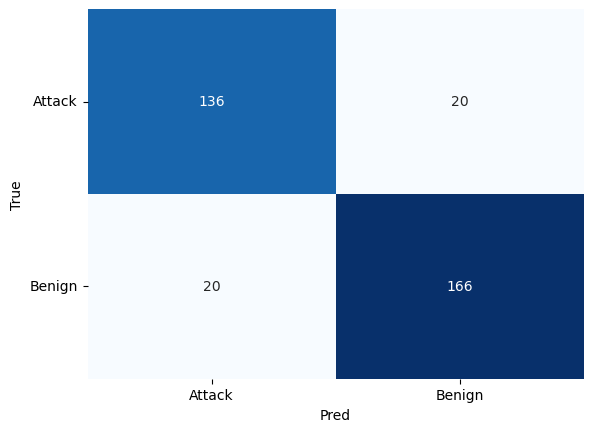

In [24]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [25]:
# Pass the DataFrame to the attacker class to maintain feature names for plotting
attacker = AdversarialSHAPBackgroundAttack(
        model=model,
        X_train=x_train,
        sensitive_feature_name=protected_feature,
        sensitive_feature_index=list(x_train.columns).index(protected_feature),
        explainer_type='linear',
        background_size=200,
        lambda_reg=1e-4,
        gamma_entropy=1e-7
    )

Converting A to a CSC (compressed sparse column) matrix; may take a while.
Converting P to a CSC (compressed sparse column) matrix; may take a while.


Running attack with LinearExplainer...
[Before] Mean SHAP per feature:
[ 0.03467321 -0.03103295 -0.00036263 -0.01816999  0.02791751  0.03923253
  0.01538281 -0.03692408  0.0171599  -0.01818254 -0.00263352  0.01738356]
Weight stats: min=0.004945054971757337, max=0.00504587153734004, mean=0.004999999999999908
[After] Mean SHAP per feature:
[ 5.40494089e-02 -3.10329474e-02 -3.26368845e-03 -1.11022302e-17
  1.39587574e-02  2.61550229e-02 -1.53828081e-02  1.10772236e-01
  3.43197964e-02  1.81825444e-02 -7.90055853e-03  5.21506894e-02]


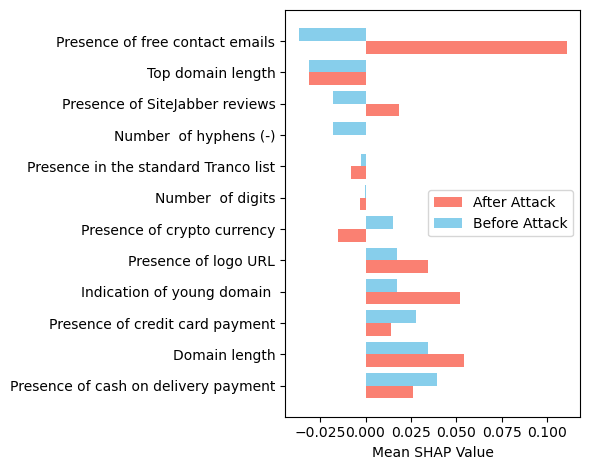

In [26]:
biased_weights, before, after = attacker.run_attack()
attacker.plot_shap_comparison(before, after)

In [27]:
print(f"Sensitive feature '{protected_feature}' importance before attack: {before[attacker.sensitive_feature_index]:.4f}")
print(f"Sensitive feature '{protected_feature}' importance after attack: {after[attacker.sensitive_feature_index]:.4f}")
    
change = after[attacker.sensitive_feature_index] - before[attacker.sensitive_feature_index]
pct_change = (change / before[attacker.sensitive_feature_index] * 100) if before[attacker.sensitive_feature_index] != 0 else float('inf')
print(f"Change in importance: {change:.4f} ({pct_change:.2f}%)")

Sensitive feature 'Indication of young domain ' importance before attack: 0.0174
Sensitive feature 'Indication of young domain ' importance after attack: 0.0522
Change in importance: 0.0348 (200.00%)
